In [1]:
from typing import List
from sharedtypes import NoteInfo
import mido
import time
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
import midi
import scipy.io.wavfile as wav
from collections import defaultdict
import sys
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece

sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models')
import helper

from onset_detection import detected_samples

In [2]:

SAMPLE_RATE = 44100
SAMPLE_LENGTH = 1000

path = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Bach_1.midi'
ret = midi.process_midi_to_note_info(path)
dic = midi.notes_to_chords(ret)
states = midi.dict_to_frequency_list(dic)
# print(states)

cov_dict = defaultdict()

sample_duration = SAMPLE_LENGTH/SAMPLE_RATE
time_samples = np.linspace(0, sample_duration, SAMPLE_LENGTH)

for state in states[:20]:
    cov_dict[str(state)] = helper.SM_kernel(time_samples, time_samples, M=10,  f=state)+ 1e-2**2 * np.eye(len(time_samples))



1it [00:00, 12.57it/s]
1it [00:00, 11.50it/s]
1it [00:00, 12.03it/s]
1it [00:00, 12.00it/s]
1it [00:00, 12.69it/s]
1it [00:00, 13.80it/s]
1it [00:00, 14.31it/s]
1it [00:00, 13.68it/s]
1it [00:00, 10.40it/s]
1it [00:00, 10.13it/s]
1it [00:00, 13.74it/s]
1it [00:00, 15.84it/s]
1it [00:00, 15.04it/s]
1it [00:00, 15.99it/s]
1it [00:00, 14.81it/s]
1it [00:00, 13.12it/s]
1it [00:00, 13.90it/s]
1it [00:00, 15.53it/s]
1it [00:00, 13.53it/s]
1it [00:00, 13.64it/s]


In [15]:
print(type(cov_dict))

<class 'collections.defaultdict'>


/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models/onset_detection.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wav.read(path)


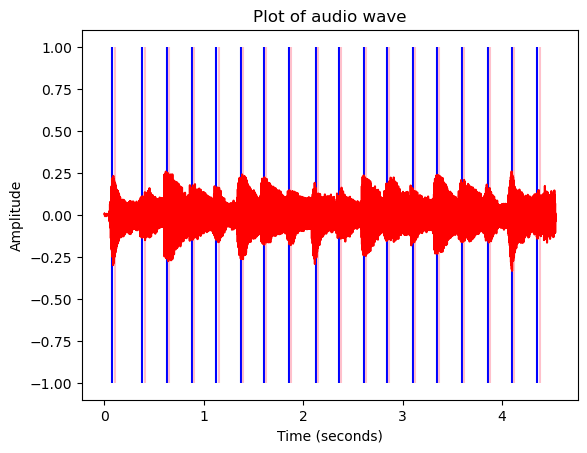

score frequencies:  [[262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [294], [440], [587], [698], [440], [587], [698], [262], [294], [440], [587], [698], [440], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [440], [659], [880], [440], [659], [880], [262], [330], [440], [659], [880], [440], [659], [880], [262], [294], [370], [440], [587], [370], [440], [587], [262], [294], [370], [440], [587], [370], [440], [587], [247], [294], [392], [587], [784], [392], [587], [784], [247], [294], [392], [587], [784], [392], [587], [784], [247], [262], [330], [392], [523], [330], [392], [523], [247], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392],

In [4]:
link =     '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/bach_1.wav'
sample_data, sample_rate, onset_times = detected_samples(
link, sample_length=1000, offset=1000, show=True, delta=0.08, num_samples=200000, normalise=False)
plt.show()
time_samples = np.linspace(
    0, len(sample_data[0])/sample_rate, len(sample_data[0]))
prob_matrix = np.zeros((len(states), len(sample_data)))

print('score frequencies: ' , states)
print(states[0])
print(type(time_samples))

In [7]:

import time
t1 = time.time()

print(-helper.stable_nlml(time_samples=time_samples, Y=sample_data[0],  M=10,normalised=False, f=[262],v = 2.37, T=0.465))
t2 = time.time()
t3 = time.time()
print(-helper.stable_nlml(time_samples=time_samples, Y=sample_data[0],cov_dict=cov_dict, M=10,normalised=False, f=[262]))
t4 = time.time()

print((t2 - t1)/(t4-t3))

1it [00:00, 13.53it/s]

2948.550084707222
2948.550084707222
8.06997600728055


In [8]:
def oltw(sample_data: list, score: list, time_samples: np.ndarray, n: int, cov_dict = None):
    note_num, audio_num = 0, 0
    path = []
    for sample in sample_data[:-n]:
        probabilities = []
        num_lookahead = min(len(score) - note_num + 1, n)
        for i in range(num_lookahead):
            if cov_dict is None:
                probabilities.append(helper.stable_nlml(time_samples=time_samples,sigma_f=0.1, Y=sample,  M=10,normalised=False, f=score[note_num+i]))
            else:
                probabilities.append(helper.stable_nlml(time_samples=time_samples,sigma_f=0.1, Y=sample,  M=10,normalised=False, f=score[note_num+i], cov_dict = cov_dict))
        # priors = 1/np.arange(1, num_lookahead+1)
        priors = np.ones(num_lookahead)
        probabilities = np.array(probabilities)
        probabilities = probabilities * priors

        index = np.argmin(probabilities)

        note_num += index
        audio_num += 1
        path.append((note_num, audio_num))
    return path


In [11]:

t1 = time.time()
oltw(sample_data, score=states, time_samples=time_samples,n=3, cov_dict=cov_dict)
t2 = time.time()

t3 = time.time()
oltw(sample_data, score=states, time_samples=time_samples,n=3)
t4 = time.time()

1it [00:00, 15.88it/s]
1it [00:00, 13.18it/s]
1it [00:00, 15.36it/s]
1it [00:00, 16.15it/s]
1it [00:00, 16.53it/s]
1it [00:00, 15.57it/s]
1it [00:00, 16.76it/s]
1it [00:00, 16.83it/s]
1it [00:00, 16.59it/s]
1it [00:00, 16.66it/s]
1it [00:00, 15.67it/s]
1it [00:00, 17.26it/s]
1it [00:00, 17.42it/s]
1it [00:00, 15.03it/s]
1it [00:00, 18.75it/s]
1it [00:00, 16.31it/s]
1it [00:00, 13.96it/s]
1it [00:00, 14.67it/s]
1it [00:00, 18.46it/s]
1it [00:00, 17.27it/s]
1it [00:00, 16.18it/s]
1it [00:00, 18.08it/s]
1it [00:00, 16.86it/s]
1it [00:00, 15.62it/s]
1it [00:00, 17.41it/s]
1it [00:00, 16.92it/s]
1it [00:00, 16.62it/s]
1it [00:00, 17.23it/s]
1it [00:00, 17.21it/s]
1it [00:00, 16.30it/s]
1it [00:00, 15.26it/s]
1it [00:00, 16.75it/s]
1it [00:00, 17.50it/s]
1it [00:00, 15.51it/s]
1it [00:00, 17.02it/s]
1it [00:00, 16.49it/s]
1it [00:00, 16.09it/s]
1it [00:00, 16.46it/s]
1it [00:00, 16.52it/s]
1it [00:00, 16.45it/s]
1it [00:00, 16.60it/s]
1it [00:00, 16.98it/s]
1it [00:00, 15.77it/s]
1it [00:00,

In [14]:
print((t4-t3)/(t2-t1))

6.4312927578880785


[(0, 1), (0, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (8, 8), (8, 9), (9, 10), (10, 11), (11, 12), (11, 13), (13, 14), (14, 15)]


/var/folders/n4/k97yk30s1wn32d7y6729kph80000gn/T/ipykernel_23200/1267370824.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wav.read(link)


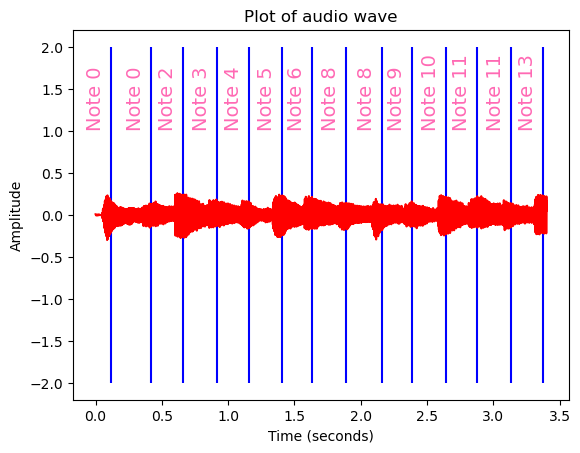

In [46]:
print(path)
sample_rate, data = wav.read(link)
data = data[:150000]
audio_duration = len(data)/sample_rate
time_samples = np.linspace(0, audio_duration, len(data))
helper.plot_audio(time_samples, data)

for i, time in enumerate(onset_times[:-4]):
    plt.vlines(time +2000/44100, ymin=-
                       2, ymax=2, colors='blue', zorder=2)
    note = path[i][0]
    plt.text(time, 1, f'Note {note}', color='#FF69B4', ha='right', va='bottom', rotation=90, fontsize=14)


In [17]:
import pyaudio
import numpy as np
import time

def callback(in_data, frame_count, time_info, status):
    # Convert the byte data to a NumPy array
    audio_data = np.frombuffer(in_data, dtype=np.int16)

    # Process the audio data (you can replace this with your own processing logic)
    processed_data = audio_data[:1000]  # Take the first 1000 samples
    print(processed_data)
    return processed_data.tobytes(), pyaudio.paContinue

# Set up PyAudio
p = pyaudio.PyAudio()

# Set parameters
format = pyaudio.paInt16
channels = 1
rate = 44100
chunk_size = 1000
sample_width = 2  # 16-bit audio

# Create a PyAudio stream
stream = p.open(format=format,
                channels=channels,
                rate=rate,
                input=True,
                frames_per_buffer=chunk_size,
                stream_callback=callback)

print("Recording...")

# Start the stream
stream.start_stream()

try:
    while stream.is_active():
        time.sleep(0.25)  # Sleep for quarter second
except KeyboardInterrupt:
    pass
finally:
    # Stop the stream and close PyAudio
    print("Recording stopped.")
    stream.stop_stream()
    stream.close()
    p.terminate()

Recording...
[ 14  28  31  30  31  31  30  29  29  32  30  32  34  33  34  34  34  31
  33  35  32  30  32  34  33  32  32  33  32  31  33  33  32  31  34  34
  31  30  31  28  29  28  26  24  27  27  24  22  21  24  25  22  21  20
  21  20  24  23  21  22  22  22  20  16  18  23  20  18  21  21  22  25
  25  24  19  20  20  19  16  15  15  15  14  11  13  15  15  11   7   7
  10   9   7   9  10   9   8   8   7   8   7   7   8  10   9   7   9  10
   8   7   8   8   8   8   4   4   3   2   2   1   1  -1   0  -1  -2  -2
  -3  -2   0  -1  -1  -3  -3  -5  -5  -7  -9  -9 -12 -14 -13 -15 -16 -16
 -18 -19 -19 -18 -18 -17 -17 -15 -17 -19 -19 -20 -19 -17 -18 -20 -18 -17
 -19 -20 -18 -21 -21 -18 -22 -27 -25 -24 -26 -25 -25 -24 -25 -28 -29 -32
 -35 -35 -31 -33 -35 -34 -32 -30 -32 -30 -31 -30 -32 -33 -31 -31 -31 -33
 -32 -29 -31 -34 -32 -28 -32 -32 -30 -32 -32 -31 -34 -32 -27 -28 -26 -27
 -30 -29 -27 -26 -28 -30 -30 -30 -29 -28 -27 -25 -23 -23 -22 -22 -25 -23
 -23 -25 -26 -26 -27 -28 -29 -27 -26 -